In [1]:
import pandas as pd
import numpy as np
import math
import time
from scipy import sparse
np.warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from scipy import sparse
from keras.initializers import Zeros
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import initializers

import sys
sys.path.append('../model')
from helper import *
from ann_nn import *

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../ml-latest/ratings.csv') 
df_tag = pd.read_csv('../ml-latest/genome-scores.csv')
df_sample = sample_df(df)
train_df, test_df = train_test_split_by_time(df_sample)

rating_train = train_df.pivot(index='movieId', columns='userId', values='rating')
rating_test = test_df.pivot(index='movieId', columns='userId', values='rating')

number of users: 20000
number of items: 1000
number of ratings: 1179969


In [3]:
#model
k_items = 10
start = time.time()  
model_ann_nn = ann_nn(max_iter=2, regparam=0.1, prerank_k=20, leaf_size=50, rank=10, 
                      batch_size=256, epochs=40, k_items=k_items, verbose = 1, use_element_embed=False)
model_ann_nn.fit(train_df, df_tag)
end = time.time()  
train_time = end - start

start = time.time()  
df_pred =  model_ann_nn.pred(test_df)
end = time.time() 
test_time = end - start 

print("train_time: ", train_time)
print("test_time: ", test_time)

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Train on 856804 samples, validate on 95201 samples
Epoch 1/40
856804/856804 [==============================] - 7s 8us/step - loss: 0.8717 - mae: 0.6998 - val_loss: 0.6525 - val_mae: 0.6198
Epoch 2/40
856804/856804 [==============================] - 6s 7us/step - loss: 0.6531 - mae: 0.6202 - val_loss: 0.6298 - val_mae: 0.6069
Epoch 3/40
856804/856804 [==============================] - 6s 7us/step - loss: 0.6338 - mae: 0.6105 - val_loss: 0.6195 - val_mae: 0.6058
Epoch 4/40
856804/856804 [==============================] - 6s 7us/step - loss: 0.6256 - mae: 0.6065 - val_loss: 0.6117 - val_mae: 0.5991
Epoch 5/40
856804/856804 [==============================] - 6s 7us/step - loss: 0.6191 - mae: 0.6033 - val_loss:

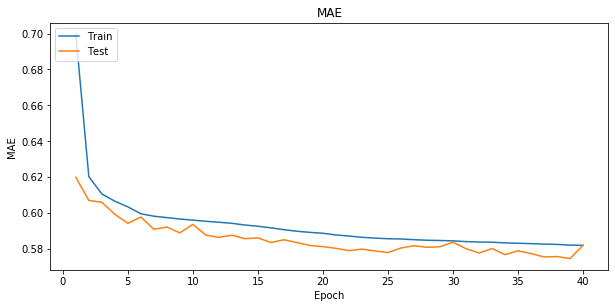

In [4]:
history = model_ann_nn.history
plot_history(history)

In [9]:
#cross validate
from tqdm import tqdm
k_items = 10

max_iter_list = [2, 5, 10, 15]
prerank_k_list = [20, 30, 50]
rank_list = [5, 10, 15, 20]
leaf_size_list = [15, 30, 50]


result = []
for max_iter in tqdm(max_iter_list):
    for prerank_k in tqdm(prerank_k_list):
        for rank in tqdm(rank_list):
            for leaf_size in tqdm(leaf_size_list):
                temp = dict()
                model_ann_nn = ann_nn(max_iter=max_iter, regparam=0.1, prerank_k=prerank_k, leaf_size=leaf_size, rank=rank, 
                                      batch_size=256, epochs=40, k_items=k_items, verbose = 0, use_element_embed=False)
                model_ann_nn.fit(train_df)
                df_pred =  model_ann_nn.pred(test_df)
                rating_pred = pd.DataFrame(index = rating_test.index, columns = ['dummy']).join(df_pred.pivot(index='movieId', columns='userId', values='rating'), how = 'left').drop('dummy', axis = 1)
                user_recalls, avg_recall = recall_over_user(rating_test, rating_pred, k_items=k_items, plot=False)
                temp['max_iter'] = max_iter
                temp['prerank_k'] = prerank_k
                temp['rank'] = rank
                temp['leaf_size'] = leaf_size
                temp['recall'] = avg_recall
                temp['history'] = model_ann_nn.history
                result.append(temp)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399963, 4)
shape of features array in test set: (399963, 10)
shape of target array in test set: (399963,)





 33%|███▎      | 1/3 [06:28<12:56, 388.48s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399963, 4)
shape of features array in test set: (399963, 10)
shape of target array in test set: (399963,)





 67%|██████▋   | 2/3 [12:43<06:24, 384.32s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399963, 4)
shape of features array in test set: (399963, 10)
shape of target array in test set: (399963,)





100%|██████████| 3/3 [18:21<00:00, 367.33s/it]


 25%|██▌       | 1/4 [18:21<55:05, 1102.00s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399960, 4)
shape of features array in test set: (399960, 20)
shape of target array in test set: (399960,)





 33%|███▎      | 1/3 [04:57<09:54, 297.26s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399960, 4)
shape of features array in test set: (399960, 20)
shape of target array in test set: (399960,)





 67%|██████▋   | 2/3 [09:53<04:56, 296.85s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399960, 4)
shape of features array in test set: (399960, 20)
shape of target array in test set: (399960,)





100%|██████████| 3/3 [14:52<00:00, 297.46s/it]


 50%|█████     | 2/4 [33:14<34:38, 1039.11s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399939, 4)
shape of features array in test set: (399939, 30)
shape of target array in test set: (399939,)





 33%|███▎      | 1/3 [05:14<10:28, 314.15s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399939, 4)
shape of features array in test set: (399939, 30)
shape of target array in test set: (399939,)





 67%|██████▋   | 2/3 [10:37<05:17, 317.00s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399939, 4)
shape of features array in test set: (399939, 30)
shape of target array in test set: (399939,)





100%|██████████| 3/3 [15:49<00:00, 316.48s/it]


 75%|███████▌  | 3/4 [49:03<16:52, 1012.21s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399857, 4)
shape of features array in test set: (399857, 40)
shape of target array in test set: (399857,)





 33%|███▎      | 1/3 [05:18<10:37, 318.93s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399857, 4)
shape of features array in test set: (399857, 40)
shape of target array in test set: (399857,)





 67%|██████▋   | 2/3 [10:38<05:18, 318.98s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399857, 4)
shape of features array in test set: (399857, 40)
shape of target array in test set: (399857,)





100%|██████████| 3/3 [15:59<00:00, 319.67s/it]


100%|██████████| 4/4 [1:05:02<00:00, 975.71s/it]

 33%|███▎      | 1/3 [1:05:02<2:10:05, 3902.85s/it]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599969, 4)
shape of features array in test set: (599969, 10)
shape of target array in test set: (599969,)





 33%|███▎      | 1/3 [05:15<10:31, 315.72s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599969, 4)
shape of features array in test set: (599969, 10)
shape of target array in test set: (599969,)





 67%|██████▋   | 2/3 [10:29<05:15, 315.13s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599969, 4)
shape of features array in test set: (599969, 10)
shape of target array in test set: (599969,)





100%|██████████| 3/3 [15:36<00:00, 312.30s/it]


 25%|██▌       | 1/4 [15:36<46:50, 936.89s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599948, 4)
shape of features array in test set: (599948, 20)
shape of target array in test set: (599948,)





 33%|███▎      | 1/3 [05:17<10:34, 317.25s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599948, 4)
shape of features array in test set: (599948, 20)
shape of target array in test set: (599948,)





 67%|██████▋   | 2/3 [10:32<05:16, 316.67s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599948, 4)
shape of features array in test set: (599948, 20)
shape of target array in test set: (599948,)





100%|██████████| 3/3 [15:52<00:00, 317.64s/it]


 50%|█████     | 2/4 [31:29<31:23, 941.71s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599926, 4)
shape of features array in test set: (599926, 30)
shape of target array in test set: (599926,)





 33%|███▎      | 1/3 [05:34<11:09, 334.91s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599926, 4)
shape of features array in test set: (599926, 30)
shape of target array in test set: (599926,)





 67%|██████▋   | 2/3 [11:06<05:34, 334.02s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599926, 4)
shape of features array in test set: (599926, 30)
shape of target array in test set: (599926,)





100%|██████████| 3/3 [16:38<00:00, 332.90s/it]


 75%|███████▌  | 3/4 [48:08<15:58, 958.80s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599893, 4)
shape of features array in test set: (599893, 40)
shape of target array in test set: (599893,)





 33%|███▎      | 1/3 [05:43<11:26, 343.18s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599893, 4)
shape of features array in test set: (599893, 40)
shape of target array in test set: (599893,)





 67%|██████▋   | 2/3 [11:20<05:41, 341.54s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599893, 4)
shape of features array in test set: (599893, 40)
shape of target array in test set: (599893,)





100%|██████████| 3/3 [16:59<00:00, 339.87s/it]


100%|██████████| 4/4 [1:05:08<00:00, 977.03s/it]

 67%|██████▋   | 2/3 [2:10:10<1:05:04, 3904.44s/it]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999974, 4)
shape of features array in test set: (999974, 10)
shape of target array in test set: (999974,)





 33%|███▎      | 1/3 [05:50<11:41, 350.63s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999974, 4)
shape of features array in test set: (999974, 10)
shape of target array in test set: (999974,)





 67%|██████▋   | 2/3 [11:37<05:49, 349.62s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999974, 4)
shape of features array in test set: (999974, 10)
shape of target array in test set: (999974,)





100%|██████████| 3/3 [17:22<00:00, 347.59s/it]


 25%|██▌       | 1/4 [17:22<52:08, 1042.78s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999951, 4)
shape of features array in test set: (999951, 20)
shape of target array in test set: (999951,)





 33%|███▎      | 1/3 [05:55<11:51, 355.61s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999951, 4)
shape of features array in test set: (999951, 20)
shape of target array in test set: (999951,)





 67%|██████▋   | 2/3 [11:52<05:55, 355.91s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999951, 4)
shape of features array in test set: (999951, 20)
shape of target array in test set: (999951,)





100%|██████████| 3/3 [17:49<00:00, 356.37s/it]


 50%|█████     | 2/4 [35:11<35:01, 1050.68s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999928, 4)
shape of features array in test set: (999928, 30)
shape of target array in test set: (999928,)





 33%|███▎      | 1/3 [06:11<12:23, 371.87s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999928, 4)
shape of features array in test set: (999928, 30)
shape of target array in test set: (999928,)





 67%|██████▋   | 2/3 [12:22<06:11, 371.49s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999928, 4)
shape of features array in test set: (999928, 30)
shape of target array in test set: (999928,)





100%|██████████| 3/3 [18:22<00:00, 367.55s/it]


 75%|███████▌  | 3/4 [53:34<17:46, 1066.27s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999904, 4)
shape of features array in test set: (999904, 40)
shape of target array in test set: (999904,)





 33%|███▎      | 1/3 [06:11<12:22, 371.29s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999904, 4)
shape of features array in test set: (999904, 40)
shape of target array in test set: (999904,)





 67%|██████▋   | 2/3 [12:21<06:10, 370.97s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999904, 4)
shape of features array in test set: (999904, 40)
shape of target array in test set: (999904,)





100%|██████████| 3/3 [18:31<00:00, 370.54s/it]


100%|██████████| 4/4 [1:12:06<00:00, 1081.55s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399992, 4)
shape of features array in test set: (399992, 10)
shape of target array in test set: (399992,)





 33%|███▎      | 1/3 [04:57<09:55, 297.57s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399992, 4)
shape of features array in test set: (399992, 10)
shape of target array in test set: (399992,)





 67%|██████▋   | 2/3 [09:58<04:58, 298.58s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399992, 4)
shape of features array in test set: (399992, 10)
shape of target array in test set: (399992,)





100%|██████████| 3/3 [15:01<00:00, 300.65s/it]


 25%|██▌       | 1/4 [15:01<45:05, 901.97s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399981, 4)
shape of features array in test set: (399981, 20)
shape of target array in test set: (399981,)





 33%|███▎      | 1/3 [05:16<10:32, 316.28s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399981, 4)
shape of features array in test set: (399981, 20)
shape of target array in test set: (399981,)





 67%|██████▋   | 2/3 [10:22<05:13, 313.32s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399981, 4)
shape of features array in test set: (399981, 20)
shape of target array in test set: (399981,)





100%|██████████| 3/3 [15:24<00:00, 308.17s/it]


 50%|█████     | 2/4 [30:26<30:17, 908.74s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399970, 4)
shape of features array in test set: (399970, 30)
shape of target array in test set: (399970,)





 33%|███▎      | 1/3 [05:14<10:29, 314.68s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399970, 4)
shape of features array in test set: (399970, 30)
shape of target array in test set: (399970,)





 67%|██████▋   | 2/3 [10:25<05:13, 313.45s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399970, 4)
shape of features array in test set: (399970, 30)
shape of target array in test set: (399970,)





100%|██████████| 3/3 [15:38<00:00, 312.70s/it]


 75%|███████▌  | 3/4 [46:04<15:17, 917.55s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399969, 4)
shape of features array in test set: (399969, 40)
shape of target array in test set: (399969,)





 33%|███▎      | 1/3 [05:19<10:39, 319.61s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399969, 4)
shape of features array in test set: (399969, 40)
shape of target array in test set: (399969,)





 67%|██████▋   | 2/3 [10:36<05:18, 318.92s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 20 pairs with ann......
top 20 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(399969, 4)
shape of features array in test set: (399969, 40)
shape of target array in test set: (399969,)





100%|██████████| 3/3 [15:52<00:00, 317.52s/it]


100%|██████████| 4/4 [1:01:57<00:00, 929.29s/it]

 33%|███▎      | 1/3 [1:01:57<2:03:54, 3717.17s/it]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599994, 4)
shape of features array in test set: (599994, 10)
shape of target array in test set: (599994,)





 33%|███▎      | 1/3 [05:20<10:40, 320.05s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599994, 4)
shape of features array in test set: (599994, 10)
shape of target array in test set: (599994,)





 67%|██████▋   | 2/3 [10:39<05:19, 319.88s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599994, 4)
shape of features array in test set: (599994, 10)
shape of target array in test set: (599994,)





100%|██████████| 3/3 [16:02<00:00, 320.99s/it]


 25%|██▌       | 1/4 [16:02<48:08, 962.96s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599987, 4)
shape of features array in test set: (599987, 20)
shape of target array in test set: (599987,)





 33%|███▎      | 1/3 [05:24<10:49, 324.98s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599987, 4)
shape of features array in test set: (599987, 20)
shape of target array in test set: (599987,)





 67%|██████▋   | 2/3 [10:43<05:22, 322.92s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599987, 4)
shape of features array in test set: (599987, 20)
shape of target array in test set: (599987,)





100%|██████████| 3/3 [16:00<00:00, 320.17s/it]


 50%|█████     | 2/4 [32:03<32:04, 962.23s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599984, 4)
shape of features array in test set: (599984, 30)
shape of target array in test set: (599984,)





 33%|███▎      | 1/3 [05:35<11:11, 335.56s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599984, 4)
shape of features array in test set: (599984, 30)
shape of target array in test set: (599984,)





 67%|██████▋   | 2/3 [11:12<05:35, 335.98s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599984, 4)
shape of features array in test set: (599984, 30)
shape of target array in test set: (599984,)





100%|██████████| 3/3 [16:44<00:00, 334.82s/it]


 75%|███████▌  | 3/4 [48:47<16:14, 974.90s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599986, 4)
shape of features array in test set: (599986, 40)
shape of target array in test set: (599986,)





 33%|███▎      | 1/3 [05:39<11:19, 339.93s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599986, 4)
shape of features array in test set: (599986, 40)
shape of target array in test set: (599986,)





 67%|██████▋   | 2/3 [11:16<05:38, 338.80s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 30 pairs with ann......
top 30 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 40)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(599986, 4)
shape of features array in test set: (599986, 40)
shape of target array in test set: (599986,)





100%|██████████| 3/3 [16:56<00:00, 338.94s/it]


100%|██████████| 4/4 [1:05:44<00:00, 986.20s/it]

 67%|██████▋   | 2/3 [2:07:41<1:03:05, 3785.46s/it]

  0%|          | 0/4 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999996, 4)
shape of features array in test set: (999996, 10)
shape of target array in test set: (999996,)





 33%|███▎      | 1/3 [05:50<11:40, 350.37s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999996, 4)
shape of features array in test set: (999996, 10)
shape of target array in test set: (999996,)





 67%|██████▋   | 2/3 [11:37<05:49, 349.53s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 10)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999996, 4)
shape of features array in test set: (999996, 10)
shape of target array in test set: (999996,)





100%|██████████| 3/3 [17:22<00:00, 347.59s/it]


 25%|██▌       | 1/4 [17:22<52:08, 1042.78s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999992, 4)
shape of features array in test set: (999992, 20)
shape of target array in test set: (999992,)





 33%|███▎      | 1/3 [05:55<11:51, 355.60s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999992, 4)
shape of features array in test set: (999992, 20)
shape of target array in test set: (999992,)





 67%|██████▋   | 2/3 [12:01<05:58, 358.56s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 20)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999992, 4)
shape of features array in test set: (999992, 20)
shape of target array in test set: (999992,)





100%|██████████| 3/3 [17:54<00:00, 358.29s/it]


 50%|█████     | 2/4 [35:17<35:04, 1052.41s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999993, 4)
shape of features array in test set: (999993, 30)
shape of target array in test set: (999993,)





 33%|███▎      | 1/3 [06:10<12:20, 370.26s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999993, 4)
shape of features array in test set: (999993, 30)
shape of target array in test set: (999993,)





 67%|██████▋   | 2/3 [12:19<06:09, 369.96s/it]

Training begins.......
Begin to retrieve latent features from MF ......
Begin to retrieve top 50 pairs with ann......
top 50 pairs are ready
creating training set for neural network......
shape of features array in train set: (952005, 30)
shape of target array in train set: (952005,)
Prediction begins.......
creating testing set for neural network.....
(999993, 4)
shape of features array in test set: (999993, 30)
shape of target array in test set: (999993,)





100%|██████████| 3/3 [18:49<00:00, 376.41s/it]


 75%|███████▌  | 3/4 [54:06<17:55, 1075.46s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

Training begins.......
Begin to retrieve latent features from MF ......


OSError: [Errno 28] No space left on device

In [15]:
# best params
best = sorted(result, key = lambda dic: dic['recall'])[-1]
best

{'max_iter': 2,
 'prerank_k': 20,
 'rank': 20,
 'leaf_size': 30,
 'recall': 0.07970414682539682,
 'history': <keras.callbacks.callbacks.History at 0x7f90dc598390>}

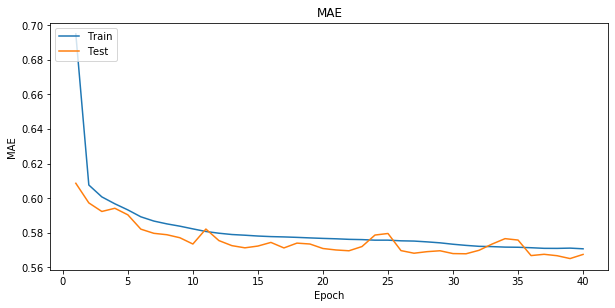

In [18]:
plot_history(best['history'])